In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

In [2]:
import time
import torch
from torch_geometric.loader import DataLoader
from tqdm import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

# from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

# from cutlass import *
# from rbfConv import *
from tqdm.notebook import tqdm
# from BasisConvolution.detail.cutlass import cutlass
from torch.nn.parameter import Parameter
import numpy as np
# from BasisConvolution.convNet import RbfNet

In [3]:
device = 'cuda'
dtype = torch.float32

In [4]:
def generateParticles(nx, dim = 1):
    dx = 2 / nx
#     nx = int(numParticles ** (1/dim))
#     print(nx)
    x = torch.linspace(-1 + dx / 2, 1 - dx/2, nx, device = device, dtype = dtype)
    y = torch.linspace(-1 + dx / 2, 1 - dx/2, nx, device = device, dtype = dtype)
    z = torch.linspace(-1 + dx / 2, 1 - dx/2, nx, device = device, dtype = dtype)
    if dim == 1:
        return x[:,None], dx
    if dim == 2:
        xx,yy = torch.meshgrid(x,y, indexing = 'xy')
        return torch.stack((xx,yy), axis = -1).flatten().reshape((-1,2)), dx
    if dim == 3:
        xx,yy,zz = torch.meshgrid(x,y,z, indexing = 'xy')
        return torch.stack((xx,yy,zz), axis = -1).flatten().reshape((-1,3)), dx

@torch.jit.script
def supportFromVolume(v, dim: int, numNeighbors: int):
#     print(v,dim,numNeighbors)
    if dim == 1:
        return (numNeighbors / 2) * v
    if dim == 2: 
        return (numNeighbors * v / np.pi) ** (1/2)
    if dim == 3:
        return (numNeighbors * v *3 / (4 * np.pi))**(1/3)
    return torch.ones_like(v) * np.nan

def neighSearch(x, y, support, max_num_neighbors):
    j,i = radius(x, y, support, max_num_neighbors = numNeighbors * 4)
    fluidDistances = y[i] - x[j]
    fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)

    fluidDistances[fluidRadialDistances < 1e-4 * support,:] = 0
    fluidDistances[fluidRadialDistances >= 1e-4 * support,:] /= fluidRadialDistances[fluidRadialDistances >= 1e-4 * support,None]
    fluidRadialDistances /= support
    return i, j, fluidDistances, fluidRadialDistances
def batchedNeighSearch(positions, h, numNeighbors):
    neighborLists = [neighSearch(xs, xs, h[0], max_num_neighbors = numNeighbors * 4) for xs in positions]
    neigh_i = [n[0] for n in neighborLists]
    neigh_j = [n[1] for n in neighborLists]
    neigh_direction = [n[2] for n in neighborLists]
    neigh_distance = [n[3] for n in neighborLists]

    for i in range(len(neighborLists) - 1):
        neigh_i[i + 1] += np.sum([positions[j].shape[0] for j in range(i+1)])
        neigh_j[i + 1] += np.sum([positions[j].shape[0] for j in range(i+1)])

    neigh_i = torch.hstack(neigh_i)
    neigh_j = torch.hstack(neigh_j)
    neigh_distance = torch.hstack(neigh_distance)
    neigh_direction = torch.vstack(neigh_direction)
    
    return neigh_i, neigh_j, neigh_distance, neigh_direction

In [5]:
# start = torch.cuda.Event(enable_timing=True)
# end = torch.cuda.Event(enable_timing=True)


# start.record()

# end.record()


# torch.cuda.synchronize()
# print(start.elapsed_time(end))

In [6]:
def stepGPUwNeighborhood(convNet, optimizer, xstar, h, numNeighbors, f, gt):    
    step_start = torch.cuda.Event(enable_timing=True)
    neigh_start = torch.cuda.Event(enable_timing=True)
    prediction_start = torch.cuda.Event(enable_timing=True)
    loss_start = torch.cuda.Event(enable_timing=True)
    backwards_start = torch.cuda.Event(enable_timing=True)  
    
    step_end = torch.cuda.Event(enable_timing=True)
    neigh_end = torch.cuda.Event(enable_timing=True)
    prediction_end = torch.cuda.Event(enable_timing=True)
    loss_end = torch.cuda.Event(enable_timing=True)
    backwards_end = torch.cuda.Event(enable_timing=True)
    
    
    step_start.record()
    optimizer.zero_grad()
    neigh_start.record()
    fi, fj, rij, direction = batchedNeighSearch(xstar, h[0], numNeighbors)
    neigh_end.record()
    
    prediction_start.record()
    prediction = convNet(f, fi, fj, direction * rij[:,None], None, None, None)
    prediction_end.record()
    
    loss_start.record()
    loss = (prediction - gt)**2
    meanLoss = torch.mean(loss)
    loss_end.record()
    
    backwards_start.record()
    meanLoss.backward()
    backwards_end.record()
    
    step_end.record()
    torch.cuda.synchronize()
    
    return step_start.elapsed_time(step_end), neigh_start.elapsed_time(neigh_end), prediction_start.elapsed_time(prediction_end), loss_start.elapsed_time(loss_end), backwards_start.elapsed_time(backwards_end)
def stepGPU(convNet, optimizer, xstar, h, numNeighbors, f, gt, fi, fj, rij, direction):    
    step_start = torch.cuda.Event(enable_timing=True)
    prediction_start = torch.cuda.Event(enable_timing=True)
    loss_start = torch.cuda.Event(enable_timing=True)
    backwards_start = torch.cuda.Event(enable_timing=True)  
    
    step_end = torch.cuda.Event(enable_timing=True)
    prediction_end = torch.cuda.Event(enable_timing=True)
    loss_end = torch.cuda.Event(enable_timing=True)
    backwards_end = torch.cuda.Event(enable_timing=True)
    
    
    step_start.record()
    optimizer.zero_grad()
    
    prediction_start.record()
    prediction = convNet(f, fi, fj, direction * rij[:,None], None, None, None)
    prediction_end.record()
    
    loss_start.record()
    loss = (prediction - gt)**2
    meanLoss = torch.mean(loss)
    loss_end.record()
    
    backwards_start.record()
    meanLoss.backward()
    backwards_end.record()
    
    step_end.record()
    torch.cuda.synchronize()
    
    return step_start.elapsed_time(step_end), prediction_start.elapsed_time(prediction_end), loss_start.elapsed_time(loss_end), backwards_start.elapsed_time(backwards_end)

In [7]:
def stepCPUwNeighborhood(convNet, optimizer, xstar, h, numNeighbors, f, gtn):    
    step_start = time.time()
    optimizer.zero_grad()

    neigh_start = time.time()
    fi, fj, rij, direction = batchedNeighSearch(xstar, h[0], numNeighbors)
    neigh_end = time.time()
    
    prediction_start = time.time()
    prediction = convNet(f, fi, fj, direction * rij[:,None], None, None, None)
    prediction_end = time.time()
    
    loss_start = time.time()
    loss = (prediction - gt)**2
    meanLoss = torch.mean(loss)
    loss_end = time.time()
    
    backwards_start = time.time()
    meanLoss.backward()
    backwards_end = time.time()
    
    step_end = time.time()
    
    return step_end - step_start, neigh_end - neigh_start, prediction_end - prediction_start, loss_end - loss_start, backwards_end - backwards_start

def stepCPU(convNet, optimizer, xstar, h, numNeighbors, f, gt, fi, fj, rij, direction):    
    step_start = time.time()
    optimizer.zero_grad()
    
    prediction_start = time.time()
    prediction = convNet(f, fi, fj, direction * rij[:,None], None, None, None)
    prediction_end = time.time()
    
    loss_start = time.time()
    loss = (prediction - gt)**2
    meanLoss = torch.mean(loss)
    loss_end = time.time()
    
    backwards_start = time.time()
    meanLoss.backward()
    backwards_end = time.time()
    
    step_end = time.time()
    
    return step_end - step_start, prediction_end - prediction_start, loss_end - loss_start, backwards_end - backwards_start

In [8]:
import pandas as pd
from BasisConvolution.detail.windows import getWindowFunction

In [9]:
def getBasisLabel(b):
    if b == 'fourier even':
        return 'Fourier (even)'
    if b == 'fourier odd':
        return 'Fourier (odd)'
    if b == 'fourier odd lin':
        return 'Fourier (odd) + x'
    if b == 'fourier odd sgn':
        return 'Fourier (odd) + sgn(x)'
    if b == 'fourier':
        return 'SFBC'
    if b == 'ffourier':
        return 'Fourier (4-Terms)'
    if b == 'ffourier 5':
        return 'Fourier (5-Terms)'
    if b == 'linear':
        return 'LinCConv'
    if b == 'rbf linear':
        return 'LinCConv'
    if b == 'abf cubic_spline':
        return 'SplineConv'
    if b == 'dmcf':
        return 'DMCF'
    if b == 'rbf square':
        return 'Nearest Neighbor'
    if b == 'chebyshev':
        return 'Chebyshev'
    if b == 'chebyshev 2':
        return 'Chebyshev (2nd kind)'
    if b == 'ubf cubic_spline':
        return 'Normalized SplineConv'
    if b == 'ubf quartic_spline':
        return 'Normalized Quartic Spline'
    if b == 'abf bump':
        return 'Bump RBF'
    if b == 'rbf linear':
        return 'CConv'
    if b == 'ubf wendland2':
        return 'Normalized Wendland-2'
    if b == 'ubf poly6':
        return 'Normalized Müller Kernel'
    if b == 'ubf gaussian':
        return 'Normalized Gaussian Kernel'
    if b == 'abf cubic_spline':
        return 'SplineConv'
    if b == 'abf gaussian':
        return 'Gaussian Kernel'
    if b == 'abf quartic_spline':
        return 'Quartic Spline'
    if b == 'abf poly6':
        return 'Müller Kernel'
    if b == 'abf wendland2':
        return 'Wendland-2'
    if b == 'rbf spiky':
        return 'Spiky'
    print('unknown basis function', b)
def getWindowLabel(w):
    if w == 'poly6':
        return 'Spiky'
    if w == 'Spiky':
        return 'Spiky Kernel'
    if w == 'Parabola':
        return r'$1-x^2$'
    if w == 'cubicSpline':
        return 'Cubic Spline'
    if w == 'quarticSpline':
        return 'Quartic Spline'
    if w == 'Linear':
        return r'$1-x$'
    if w == 'None':
        return 'None'
    if w == 'Mueller':
        return 'Müller'
    print('unknown window function', w)
    if np.isnan(w):
        return 'None'
    
def getMapLabel(w):
    if w == 'cartesian':
        return 'Cartesian'
    if w == 'polar':
        return 'Polar'
    if w == 'preserving':
        return 'Ummenhofer et al.'
    print('unknown mapping function', w)
    
import copy
def pivotDS(dataset, metrics = None):
    baseData = pd.DataFrame()
    for k in dataset.keys():
        if k not in metrics:
            baseData[k] = dataset[k]
# baseData['label'] = dataset[['rbf_x','n','map']].apply(lambda x: getBasisLabel(x[0])  + " x " + str(x[1]) + ' @ ' + getMapLabel(x[2]), axis = 1)
# baseData['Basis'] = dataset['rbf_x'].apply(getBasisLabel)
# baseData['map'] = dataset['map'].apply(getMapLabel)
# baseData['n'] = dataset['n']
# baseData['seed']= dataset['seed']
# baseData['window']= dataset['window'].apply(getWindowLabel)
# baseData['Configuration'] = baseData[['window','map']].apply(lambda x: 'Window: ' + x[0] + ' @ Map: ' + x[1], axis = 1)
# baseData['arch']=dataset['arch']
# baseData['testFile']= dataset['testFile']
# baseData['initialFrame']= dataset['initialFrame']
# baseData['unrollStep']= dataset['unrollStep']

    processedData = pd.DataFrame()
    for metric in tqdm(metrics):
        tempData = copy.deepcopy(baseData)
        tempData['metric'] = metric
        tempData['value'] = dataset[metric]
        processedData = pd.concat((processedData, tempData), ignore_index = True)
    return processedData

In [10]:
cutlassBatchSize = 32

In [11]:
def benchmarkNetwork(nx, dim, numNeighbors, fluidFeatures, cmap, rbf, n, batch_size, arch, window_fn, performanceSamples = 256, benchmarkNeighSearch = False, seed = 12345):
    torch.manual_seed = seed
    x, dx = generateParticles(nx, dim = dim)
    v = torch.ones_like(x) * dx**dim
    h = supportFromVolume(v, dim, 32)
#     print(x.shape)
    jitter = [torch.normal(torch.zeros_like(x), torch.ones_like(x) * h * jitterAmount).type(dtype).to(device) for b in range(batch_size)]
    f = torch.vstack([torch.normal(torch.zeros([x.shape[0], fluidFeatures]), torch.ones([x.shape[0], fluidFeatures])).type(dtype).to(device) for b in range(batch_size)])
    gt = torch.vstack([torch.normal(torch.zeros([x.shape[0], 1]), torch.ones([x.shape[0], 1])).type(dtype).to(device) for b in range(batch_size)])
    xstar = [x + j for j in jitter]

    convNet = RbfNet(fluidFeatures, 0, layers = arch, coordinateMapping = cmap, dims = [n] * dim, rbfs = [rbf] * dim, batchSize = cutlassBatchSize, ignoreCenter = True, normalized = False, windowFn = getWindowFunction(window_fn)).to(device)
    optimizer = Adam(convNet.parameters(), lr=1e-2, weight_decay = 0)
    performanceDataset = pd.DataFrame()
    
    neigh_start = time.time()
    fi, fj, rij, direction = batchedNeighSearch(xstar, h[0], numNeighbors)
    neigh_end = time.time()
    neighTime = neigh_end - neigh_start
    
    for i in tqdm(range(performanceSamples), leave = False):
        if benchmarkNeighSearch:
            if device == 'cpu':
                stepTime, neighTime, predTime, lossTime, backwardsTime = stepCPUwNeighborhood(convNet, optimizer, xstar, h, numNeighbors, f, gt)
            else:
                stepTime, neighTime, predTime, lossTime, backwardsTime = stepGPUwNeighborhood(convNet, optimizer, xstar, h, numNeighbors, f, gt)
        else:
            if device == 'cpu':
                stepTime, predTime, lossTime, backwardsTime = stepCPU(convNet, optimizer, xstar, h, numNeighbors, f, gt,fi,fj,rij,direction)
            else:
                stepTime, predTime, lossTime, backwardsTime = stepGPU(convNet, optimizer, xstar, h, numNeighbors, f, gt,fi,fj,rij,direction)
        frame = pd.DataFrame({
            'Sample': i,
            'Number of Particles': nx**dim,
            'Dimensionality': dim,
            'Neighborhood Size': numNeighbors,
            'Fluid Features': fluidFeatures,
            'Coordinate Mapping': cmap,
            'Window Function': window_fn,
            'Base Function': rbf,
            'Terms':n,
            'Batch Size': batch_size,
            'Network Architecture':'[%s]'% (', '.join([str(a) for a in arch])),
            'Gradient Update': stepTime,
            'Neighborsearch': neighTime,
            'Forward Pass': predTime,
            'Loss Computation': lossTime,
            'Backward Pass': backwardsTime,        
        }, [0])
        performanceDataset = pd.concat((performanceDataset, frame), ignore_index=True)
    return performanceDataset

def getPalette(hueVar, pivotedDataset):
    # st.write(ablationStudy.keys())
    methods = ['Nearest Neighbor', 'LinCConv', 'SplineConv', 'Gaussian Kernel', 'Müller Kernel', 'Wendland-2', 'Quartic Spline', 'Chebyshev', 'Chebyshev (2nd kind)', 'Fourier (even)', 'Fourier (odd)', 'Fourier', 'DMCF', 'PointNet', 'DPCConv', 'GNS', 'MP-PDE', 'Spiky', 'Bump RBF']
    actualBases = None
    if hueVar == 'Base Function':
        # palette = sns.color_palette('tab20', len(ablationStudy[hueVar].unique()))
        actualBases = pivotedDataset['Base Function'].unique()
        actualBases = [b for b in actualBases if b in methods]
        if 'SFBC' in pivotedDataset['Base Function'].unique():
            actualBases.append('Fourier')
        actualBases.sort(key = lambda i: methods.index(i))
        # st.write(actualBases)
        # if 'SFBC' in ablationStudy['Base Function'].unique():
            # actualBases[actualBases.index('Fourier')] = 'SFBC'

        palette = sns.color_palette('tab20', len(methods))
        # palette[0] = (0,1,0)
        # st.write(actualBases)
        # st.write(actualBases.index('LinCConv'))
        actualPalette = [None] * len(actualBases)
        for b in actualBases:
            if b == 'SFBC': continue
            actualPalette[actualBases.index(b)] = palette[methods.index(b)]
        if 'Fourier' in actualBases:
            actualPalette[actualBases.index('Fourier')] = (0,0,1)
        if 'SFBC' in actualBases:
            actualPalette[actualBases.index('SFBC')] = (0,0,1)
        if 'SFBC' in pivotedDataset['Base Function'].unique():
            actualBases[actualBases.index('Fourier')] = 'SFBC'
        if 'LinCConv' in actualBases:
            actualPalette[actualBases.index('LinCConv')] = (1,0,0)
        palette = actualPalette
    else:
        palette = sns.color_palette('tab20', len(pivotedDataset[hueVar].unique()))
    return actualBases, palette

In [12]:
3 * 3 * 10 * 4 * 2 * 3 * 5

10800

In [13]:
# nx = 16
# dim = 3
# jitterAmount = 0.05
# numNeighbors = 32
# fluidFeatures = 1
# cmap = 'cartesian'
# rbf = 'linear'
# n = 4
# arch = [1]
# batch_size = 4
# performanceSamples = 64
# window_fn = 'None'

# performanceDataset = pd.DataFrame()
# for arch in tqdm([[1], [32, 1], [32, 32, 1]]):
#     for [nx, dim] in tqdm([[4096, 1], [64, 2], [16, 3]], leave = False):
#         for n in tqdm([1,2,3,4,5,6,7,8,16,32], leave = False):
#             for batch_size in tqdm([2], leave = False):
#                 for window_fn in tqdm(['None', 'Mueller'], leave = False):
#                     for cmap in tqdm(['cartesian', 'polar', 'preserving'] if dim != 1 else ['cartesian'], leave = False):
#                         for rbf in tqdm(['linear', 'rbf square', 'chebyshev', 'fourier', 'dmcf'], leave = False):
#                             frame = benchmarkNetwork(nx, dim, numNeighbors, fluidFeatures, cmap, rbf, n, batch_size, arch, window_fn, performanceSamples)
#                             performanceDataset = pd.concat((performanceDataset, frame), ignore_index = True)
#                             performanceDataset.to_csv('performance [nx = %4d, dim = %d, arch = %s].csv' % (nx, dim, arch))



# # display(performanceDataset)
# performanceDataset['Base Function'] =  performanceDataset['Base Function'].apply(getBasisLabel)
# performanceDataset['Coordinate Mapping'] =  performanceDataset['Coordinate Mapping'].apply(getMapLabel)
# performanceDataset['Window Function'] =  performanceDataset['Window Function'].apply(getWindowLabel)

In [14]:
nx = 16
dim = 3
jitterAmount = 0.05
numNeighbors = 32
fluidFeatures = 1
cmap = 'cartesian'
rbf = 'linear'
n = 4
arch = [1]
batch_size = 4
performanceSamples = 64
window_fn = 'None'
# frame = benchmarkNetwork(32, 3, 32, 1, 'cartesian', 'linear', 4, 4, [32, 32, 1], None, 32)

  0%|          | 0/32 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
from opt_einsum import contract
import opt_einsum as oe

In [16]:
import math
def si_classifier(val):
    suffixes = {
        24:{'long_suffix':'yotta', 'short_suffix':'Y', 'scalar':10**24},
        21:{'long_suffix':'zetta', 'short_suffix':'Z', 'scalar':10**21},
        18:{'long_suffix':'exa', 'short_suffix':'E', 'scalar':10**18},
        15:{'long_suffix':'peta', 'short_suffix':'P', 'scalar':10**15},
        12:{'long_suffix':'tera', 'short_suffix':'T', 'scalar':10**12},
        9:{'long_suffix':'giga', 'short_suffix':'G', 'scalar':10**9},
        6:{'long_suffix':'mega', 'short_suffix':'M', 'scalar':10**6},
        3:{'long_suffix':'kilo', 'short_suffix':'k', 'scalar':10**3},
        0:{'long_suffix':'', 'short_suffix':'', 'scalar':10**0},
        -3:{'long_suffix':'milli', 'short_suffix':'m', 'scalar':10**-3},
        -6:{'long_suffix':'micro', 'short_suffix':'µ', 'scalar':10**-6},
        -9:{'long_suffix':'nano', 'short_suffix':'n', 'scalar':10**-9},
        -12:{'long_suffix':'pico', 'short_suffix':'p', 'scalar':10**-12},
        -15:{'long_suffix':'femto', 'short_suffix':'f', 'scalar':10**-15},
        -18:{'long_suffix':'atto', 'short_suffix':'a', 'scalar':10**-18},
        -21:{'long_suffix':'zepto', 'short_suffix':'z', 'scalar':10**-21},
        -24:{'long_suffix':'yocto', 'short_suffix':'y', 'scalar':10**-24}
    }
    exponent = int(math.floor(math.log10(abs(val))/3.0)*3)
    return suffixes.get(exponent, None)

def si_formatter(value):
    '''
    Return a triple of scaled value, short suffix, long suffix, or None if
    the value cannot be classified.
    '''
    classifier = si_classifier(value)
    if classifier == None:
        # Don't know how to classify this value
        return None

    scaled = value / classifier['scalar']
    return (scaled, classifier['short_suffix'], classifier['long_suffix'])

def si_format(value, precision=4, long_form=False, separator=''):
    '''
    "SI prefix" formatted string: return a string with the given precision
    and an appropriate order-of-3-magnitudes suffix, e.g.:
        si_format(1001.0) => '1.00K'
        si_format(0.00000000123, long_form=True, separator=' ') => '1.230 nano'
    '''
    scaled, short_suffix, long_suffix = si_formatter(value)

    if scaled == None:
        # Don't know how to format this value
        return value

    suffix = long_suffix if long_form else short_suffix

    if abs(scaled) < 10:
        precision = precision - 1
    elif abs(scaled) < 100:
        precision = precision - 2
    else:
        precision = precision - 3

    return '{scaled:.{precision}f}{separator}{suffix}'.format(
        scaled=scaled, precision=precision, separator=separator, suffix=suffix)

In [17]:
def formatFLOP(num):
    f = si_formatter(num)
    return '%6.2f %sFLOP' % (f[0],f[1])

from BasisConvolution.detail.basis import *
from BasisConvolution.detail.scatter import scatter_sum

In [18]:
@torch.jit.script
def evalBasisFunction(n : int, x : torch.Tensor, which : str = 'chebyshev', periodic : bool = False):   
    s = which.split()    
    if s[0] == 'chebyshev':
        return evalChebSeries(n, x)
    if s[0] == 'chebyshev2':
        return evalChebSeries2(n, x)
    if 'fourier' in which:
        return buildFourierSeries(n, x * np.pi, kind = which)
    if s[0] == 'linear':
        return evalRBFSeries(n, x, which = 'linear', epsilon = 1., periodic = periodic)        
    if s[0] == 'dmcf':
        return evalRBFSeries(n, x, which = 'linear', epsilon = 1., periodic = periodic)      #torch.sign(x) * evalRBFSeries(n, torch.abs(x) * 2 - 1, which = 'linear', epsilon = 1., periodic = periodic)              
    if s[0] == 'rbf':
        eps = 1. if len(s) < 3 else float(s[2])
        return evalRBFSeries(n, x, which = s[1], epsilon = eps, periodic = periodic)     
    if s[0] == 'abf':
        eps = 1. if len(s) < 3 else float(s[2])
        return evalRBFSeries(n, x, which = s[1], epsilon = eps, periodic = periodic, adjustSpacing = True)     
    if s[0] == 'ubf':
        eps = 1. if len(s) < 3 else float(s[2])
        return evalRBFSeries(n, x, which = s[1], epsilon = eps, periodic = periodic, normalized = True)
    return torch.ones([n,x.shape[0]], device= x.device, dtype = x.dtype) * np.nan

In [19]:
from typing import List

In [20]:
@torch.jit.script
def convolutionOp(edge_index : torch.Tensor, features_i : torch.Tensor, features_j : torch.Tensor, edge_attr : torch.Tensor, edge_weights : torch.Tensor, weight : torch.Tensor, 
                  dim_size : int, dim : int, size : List[int], rbfs : List[str], periodic : List[bool], forwardBatchSize : int, backwardBatchSize : int, normalized: bool = False):
    with record_function("convolution op - Feature Lookup"): 
        x_j = features_j[edge_index[1]]
    with record_function("convolution op - Weight Function Application"): 
        x_j = x_j if edge_weights is None else x_j * edge_weights[:,None]
    with record_function("convolution op - Batch Generation"): 
        indices = torch.arange(0,edge_attr.shape[0]).to(features_j.device)            
        batches = torch.split(indices, forwardBatchSize * 1024)
    
    with record_function("convolution op - Output Allocation"): 
        out = features_i.new_zeros((features_i.shape[0], weight.shape[-1])).type(features_i.dtype)

    for batch in batches:
        with record_function("convolution op - Batch"): 
            with record_function("convolution op - Batch - DMCF Mapping"): 
                coords = [edge_attr[batch,i] for i in range(edge_attr.shape[1])]
                mask = coords[0] < 0
                if rbfs[0] == 'dmcf':
                    for i in range(edge_attr.shape[1]-1, -1, -1):
                        coords[i][mask] = -coords[i][mask]
                    coords[0] = 2 * coords[0] - 1
                else:
                    s = None
    #         print(coords)
            with record_function("convolution op - Batch - Basis Function Eval"): 
                basisValues = [torch.transpose(evalBasisFunction(size[i], coords[i], which = rbfs[i], periodic = periodic[i]),1,0) for i in range(edge_attr.shape[1])]
    #         print(basisValues)
            with record_function("convolution op - Batch - DMCF Back Mapping"): 
                if rbfs[0] == 'dmcf':
                    basisValues[0][mask] = -basisValues[0][mask]
            with record_function("convolution op - Batch - Convolution"): 
                if edge_attr.shape[1] == 1:
                    conv = torch.einsum('nu, uio,ni -> no',basisValues[0],weight, x_j[batch])
                elif edge_attr.shape[1] == 2:
#                     b = torch.bmm(basisValues[0].unsqueeze(2), basisValues[1].unsqueeze(1))
#                     weightT = weight.permute(2,3,0,1).flatten(2).flatten(0,1)
#                     bM = b.reshape(-1,size[0] * size[1])
#                     res = torch.matmul(bM, weight.permute(0,1,3,2).flatten(0,1).flatten(1,2)).reshape(-1, weight.shape[-2], weight.shape[-1])
#                     res.reshape(-1, weight.shape[-2], weight.shape[-1])
#                     conv = torch.matmul(res, x_j[batch].unsqueeze(2))[:,:,0]
                    conv = torch.einsum('nu, nv, uvio,ni -> no',basisValues[0],basisValues[1],weight, x_j[batch])
                else:
                    conv = torch.einsum('nu, nv, nw, uvwio,ni -> no',basisValues[0],basisValues[1],basisValues[2],weight, x_j[batch])
            with record_function("convolution op - Batch - Scatter"): 
                out += scatter_sum(conv, index = edge_index[0,batch], dim_size = dim_size, dim = dim)
    return out
#         print(basisValues)
#             x = torch.abs(x)
#         print(x)

In [21]:
numParticles = 1024
numNeighbors = 32
neighborVariance = 4
dim = 3
neighborDistribution = 'close'
neighDistance = 128
numInputFeatures = 32
numOutputFeatures = 32
basis = 'dmcf'
periodic = False
numBasisTerms = 8
useEdgeWeights = True
cutlassBatchSize = 32
dtype = torch.float32
device = 'cuda'
numSamples = 32

parameterDict = {
    'Number of Samples': numSamples,
    'Particles': numParticles,
    'Dimensionality': dim,
    'Neighbors': numNeighbors,
    'Neighbor Distribution': neighborDistribution,
    'Neighbor Distance': neighDistance,
    'Neighbor Variance': neighborVariance,
    'Basis' : basis,
    'Periodic': periodic,
    'Normalized' : False,
    'Basis Terms': numBasisTerms,
    'Input Features' : numInputFeatures,
    'Output Features': numOutputFeatures,
    'Edge Weights': useEdgeWeights,
    'Batch Size': cutlassBatchSize,
    'Device': device,
    'Type': dtype,
}

In [22]:
@torch.jit.script
def generateNeighbors(ni, neighborDistribution: str, edges : int, device: torch.device, numParticles: int, neighborDistance: int):
    if neighborDistribution == 'uniform':
        fi = torch.randint(0, numParticles, (edges,1))[:,0]
        ii = torch.zeros(edges, dtype = torch.long)
        jj = torch.zeros(edges, dtype = torch.long)
        counter = 0
        for i in range(0, numParticles):
            numNeighs = ni[i]
            ii[counter: counter + numNeighs] = i
            jj[counter: counter + numNeighs] = fi[counter: counter + numNeighs]
            counter += ni[i]
        return ii, jj
    if neighborDistribution == 'close':
        fi = torch.randint(-neighborDistance, neighborDistance, (edges,1))[:,0]
        ii = torch.zeros(edges, dtype = torch.long)
        jj = torch.zeros(edges, dtype = torch.long)
        counter = 0
        for i in range(0, numParticles):
            numNeighs = ni[i]
            ii[counter: counter + numNeighs] = i
            jj[counter: counter + numNeighs] = torch.remainder(i + fi[counter: counter + numNeighs], numParticles)
#             for xi in range(0, ni[i]):
#                 ii[counter + xi] = i
#                 jj[counter + xi] = torch.remainder(i + fi[counter + xi], numParticles)
            counter += ni[i]
        return ii, jj

In [23]:

device = parameterDict['Device']
dtype = parameterDict['Type']

ni = torch.randint(parameterDict['Neighbors'] - parameterDict['Neighbor Variance'], parameterDict['Neighbors'] + parameterDict['Neighbor Variance'], (parameterDict['Particles'],1))[:,0].type(torch.long).to(device)
edges = torch.sum(ni).cpu().item()
generateNeighbors(ni, parameterDict['Neighbor Distribution'], edges, device, parameterDict['Particles'], parameterDict['Neighbor Distance'])

(tensor([   0,    0,    0,  ..., 1023, 1023, 1023]),
 tensor([  73, 1002,  107,  ...,  904,   47,  925]))

In [24]:
def prepData(parameterDict):
    device = parameterDict['Device']
    dtype = parameterDict['Type']
    
    ni = torch.randint(parameterDict['Neighbors'] - parameterDict['Neighbor Variance'], parameterDict['Neighbors'] + parameterDict['Neighbor Variance'], (parameterDict['Particles'],1))[:,0].type(torch.long).to(device)
    edges = torch.sum(ni).cpu().item()
    FloatingOperations = edges * (parameterDict['Basis Terms']**parameterDict['Dimensionality'] + 2 * parameterDict['Basis Terms']**parameterDict['Dimensionality'] 
                                  * parameterDict['Input Features'] * parameterDict['Output Features'] + parameterDict['Input Features']*parameterDict['Output Features'] - parameterDict['Output Features'])
    ii, jj = generateNeighbors(ni, parameterDict['Neighbor Distribution'], edges, device, parameterDict['Particles'], parameterDict['Neighbor Distance'])

    edge_index = torch.vstack((ii,jj)).type(torch.long).to(device)

    fj = torch.randn((parameterDict['Particles'], parameterDict['Input Features'])).type(dtype).to(device)

    weight = torch.randn([parameterDict['Basis Terms']] * parameterDict['Dimensionality'] + [parameterDict['Input Features']] + [parameterDict['Output Features']]).type(dtype).to(device)

    edge_attr = (torch.rand((edges, parameterDict['Dimensionality'])) * 2 - 1).type(dtype).to(device)
    edge_weights = torch.abs(torch.randn((edges,1)))[:,0].type(dtype).to(device) if parameterDict['Edge Weights'] else None
    
    return edge_index, fj, edge_attr, edge_weights, weight, FloatingOperations

In [25]:
parameterDict['Input Features'] = 16
parameterDict['Output Features'] = 4
parameterDict['Dimensionality'] = 2

In [26]:
def benchmark(parameterDict):
    edge_index, fj, edge_attr, edge_weights, weight, FloatingOperations = prepData(parameterDict)
    timings = []
    for i in tqdm(range(parameterDict['Number of Samples'] + 2), leave = False):
        torch.cuda.synchronize()
        start = time.time()
        convolutionOp(edge_index, fj, fj, edge_attr, edge_weights, weight, 
                      parameterDict['Particles'], 0, 
                      [parameterDict['Basis Terms']] * parameterDict['Dimensionality'], [parameterDict['Basis']] * parameterDict['Dimensionality'], [parameterDict['Periodic']] * parameterDict['Dimensionality'], 
                      parameterDict['Batch Size'], parameterDict['Batch Size'], parameterDict['Normalized']).shape
        torch.cuda.synchronize()
        end = time.time()
        if i < 2:
            continue
        timings.append((end - start) * 1000)
    df = pd.DataFrame({
        'Edges': edges,
        'GFLOP' : FloatingOperations / 10**9,
        'Mean Timing': np.mean(timings),
        'Min Timing': np.min(timings),
        'Max Timing': np.max(timings),
        'GFLOPs': [FloatingOperations / (t / 1000) / 10**9for t in timings],
        'Timing': timings
    }, index = np.arange(parameterDict['Number of Samples']))
    for k in parameterDict.keys():
        df[k] = parameterDict[k]
    return df
df = benchmark(parameterDict)
# display(df)

  0%|          | 0/34 [00:00<?, ?it/s]

In [29]:
parameterDict['Particles'] = 4096
parameterDict['Dimensionality'] = 2
parameterDict['Basis Terms'] = 4
parameterDict['Input Features'] = 32
parameterDict['Output Features'] = 32
parameterDict['Device'] = device
parameterDict['Type'] = dtype
parameterDict['Basis'] = basis
parameterDict['Neighbors'] = 32
parameterDict['Batch Size'] = 256
parameterDict['Neighbor Distribution'] = distribution
parameterDict['Number of Samples'] = 128
df = benchmark(parameterDict)
display(df)

NameError: name 'distribution' is not defined

In [31]:
parameterDict['Particles'] = 4096
parameterDict['Dimensionality'] = 2
parameterDict['Basis Terms'] = 4
parameterDict['Input Features'] = 32
parameterDict['Output Features'] = 32
parameterDict['Device'] = device
parameterDict['Type'] = dtype
parameterDict['Basis'] = basis
parameterDict['Neighbors'] = 32
parameterDict['Batch Size'] = 256
parameterDict['Neighbor Distribution'] = 'close'
parameterDict['Number of Samples'] = 128
df = benchmark(parameterDict)
display(df)

  0%|          | 0/130 [00:00<?, ?it/s]

,Edges,GFLOP,Mean Timing,Min Timing,Max Timing,GFLOPs,Timing,Number of Samples,Particles,Dimensionality,...,Basis,Periodic,Normalized,Basis Terms,Input Features,Output Features,Edge Weights,Batch Size,Device,Type
0,32321,4.364197,7.035717,4.669428,12.89463,441.962691,9.874582,128,4096,2,...,dmcf,False,False,4,32,32,True,256,cuda,torch.float32
1,32321,4.364197,7.035717,4.669428,12.89463,581.232933,7.508516,128,4096,2,...,dmcf,False,False,4,32,32,True,256,cuda,torch.float32
2,32321,4.364197,7.035717,4.669428,12.89463,507.816922,8.594036,128,4096,2,...,dmcf,False,False,4,32,32,True,256,cuda,torch.float32
3,32321,4.364197,7.035717,4.669428,12.89463,582.323878,7.494450,128,4096,2,...,dmcf,False,False,4,32,32,True,256,cuda,torch.float32
4,32321,4.364197,7.035717,4.669428,12.89463,547.899332,7.965326,128,4096,2,...,dmcf,False,False,4,32,32,True,256,cuda,torch.float32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,32321,4.364197,7.035717,4.669428,12.89463,454.630027,9.599447,128,4096,2,...,dmcf,False,False,4,32,32,True,256,cuda,torch.float32
124,32321,4.364197,7.035717,4.669428,12.89463,604.816414,7.215738,128,4096,2,...,dmcf,False,False,4,32,32,True,256,cuda,torch.float32
125,32321,4.364197,7.035717,4.669428,12.89463,765.889907,5.698204,128,4096,2,...,dmcf,False,False,4,32,32,True,256,cuda,torch.float32
126,32321,4.364197,7.035717,4.669428,12.89463,735.249388,5.935669,128,4096,2,...,dmcf,False,False,4,32,32,True,256,cuda,torch.float32


In [33]:
# dim_size : int, dim : int, size : List[int], rbfs : List[str], periodic : List[bool], forwardBatchSize : int, backwardBatchSize : int, normalized: bool = False
                                
dim_size = parameterDict['Particles']
dim = 0
size =                       [parameterDict['Basis Terms']] * parameterDict['Dimensionality']
rbfs = [parameterDict['Basis']] * parameterDict['Dimensionality']
periodic = [parameterDict['Periodic']] * parameterDict['Dimensionality']
forwardBatchSize =  parameterDict['Batch Size']
backwardBatchSize = parameterDict['Batch Size']
normalized = parameterDict['Normalized']
        
edge_index, fj, edge_attr, edge_weights, weight, FloatingOperations = prepData(parameterDict)
features_j = fj
features_i = fj
forwardBatchSize = parameterDict['Batch Size']
    
with record_function("convolution op - Feature Lookup"): 
    x_j = features_j[edge_index[1]]
with record_function("convolution op - Weight Function Application"): 
    x_j = x_j if edge_weights is None else x_j * edge_weights[:,None]
with record_function("convolution op - Batch Generation"): 
    indices = torch.arange(0,edge_attr.shape[0]).to(features_j.device)            
    batches = torch.split(indices, forwardBatchSize * 1024)

with record_function("convolution op - Output Allocation"): 
    out = features_i.new_zeros((features_i.shape[0], weight.shape[-1])).type(features_i.dtype)

for batch in batches:
    with record_function("convolution op - Batch"): 
        with record_function("convolution op - Batch - DMCF Mapping"): 
            coords = [edge_attr[batch,i] for i in range(edge_attr.shape[1])]
            mask = coords[0] < 0
            if rbfs[0] == 'dmcf':
                for i in range(edge_attr.shape[1]-1, -1, -1):
                    coords[i][mask] = -coords[i][mask]
                coords[0] = 2 * coords[0] - 1
            else:
                s = None
#         print(coords)
        with record_function("convolution op - Batch - Basis Function Eval"): 
            basisValues = [torch.transpose(evalBasisFunction(size[i], coords[i], which = rbfs[i], periodic = periodic[i]),1,0) for i in range(edge_attr.shape[1])]
#         print(basisValues)
        with record_function("convolution op - Batch - DMCF Back Mapping"): 
            if rbfs[0] == 'dmcf':
                basisValues[0][mask] = -basisValues[0][mask]
        with record_function("convolution op - Batch - Convolution"): 
            if edge_attr.shape[1] == 1:
                conv = torch.einsum('nu, uio,ni -> no',basisValues[0],weight, x_j[batch])
            elif edge_attr.shape[1] == 2:
                b = torch.bmm(basisValues[0].unsqueeze(2), basisValues[1].unsqueeze(1))
                weightT = weight.permute(2,3,0,1).flatten(2).flatten(0,1)
                bM = b.reshape(-1,size[0] * size[1])
                res = torch.matmul(bM, weight.permute(0,1,3,2).flatten(0,1).flatten(1,2)).reshape(-1, weight.shape[-2], weight.shape[-1])
                res.reshape(-1, weight.shape[-2], weight.shape[-1])
                convB = torch.matmul(res, x_j[batch].unsqueeze(2))[:,:,0]
                conv = torch.einsum('nu, nv, uvio,ni -> no',basisValues[0],basisValues[1],weight, x_j[batch])
            else:
                conv = torch.einsum('nu, nv, nw, uvwio,ni -> no',basisValues[0],basisValues[1],basisValues[2],weight, x_j[batch])
        with record_function("convolution op - Batch - Scatter"): 
            out += scatter_sum(conv, index = edge_index[0,batch], dim_size = dim_size, dim = dim)

In [ ]:

print(weightT.shape, bM.shape)

In [ ]:

print(res.shape)

In [ ]:
print(weight.shape)

In [ ]:

convA = torch.einsum('nu, nv, uvio,ni -> no',basisValues[0],basisValues[1],weight, x_j[batch])
convA.shape

In [ ]:
b.shape

In [34]:
torch.matmul(basisValues[0], weight.flatten(1)).reshape(-1, *weight.shape[1:]).shape

torch.Size([129080, 4, 32, 32])

In [591]:
b = torch.bmm(basisValues[0].unsqueeze(2), basisValues[1].unsqueeze(1))
print(b.shape)
weightT = weight.permute(2,3,0,1).flatten(2).flatten(0,1)
bM = b.reshape(-1,size[0] * size[1])
res = torch.matmul(bM, weight.permute(0,1,3,2).flatten(0,1).flatten(1,2)).reshape(-1, weight.shape[-2], weight.shape[-1])
res.reshape(-1, weight.shape[-2], weight.shape[-1])
convB = torch.matmul(res, x_j[batch].unsqueeze(2))[:,:,0]
convB.shape

torch.Size([129128, 4, 4])


torch.Size([129128, 32])

In [590]:
convB - convA

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [472]:
# devices = ['cpu', 'cuda']
# dtypes = [torch.float32, torch.float64]
# particleCounts = [256, 1024, 4096, 4096 * 4, 4096 * 16]
# dims = [1,2,3]
# ns = [1,2,4,8,16]
# bases = ['linear', 'dmcf', 'fourier']
# inFeatures = [1,2,4,8,16,32]
# outFeatures = [1,2,4,8,16,32]
# neighborCounts = [8,16,32,64]
# neighborDistributions = ['close', 'uniform']

# combinations = len(devices) * len(dtypes) * len(particleCounts) * len(dims) * len(ns) * len(bases) * len(inFeatures) * len (outFeatures) * len(neighborCounts) * len(neighborDistributions)

# print('Running Benchmark for:')
# print('[%2d] Devices:        ' % len(devices), devices)
# print('[%2d] Types:          ' % len(dtypes), dtypes)
# print('[%2d] Particles:      ' % len(particleCounts), particleCounts)
# print('[%2d] Neighbor Counts:' % len(neighborCounts), neighborCounts)
# print('[%2d] Distributions:  ' % len(neighborDistributions), neighborDistributions)
# print('[%2d] Dimensions:     ' % len(dims), dims)
# print('[%2d] Terms:          ' % len(ns), ns)
# print('[%2d] Bases:          ' % len(bases), bases)
# print('[%2d] Input Features: ' % len(inFeatures), inFeatures)
# print('[%2d] Output Features:' % len(outFeatures), outFeatures)
# print('Total Combinatons:', combinations)
# print('---------------------------------')


# benchmarkDataset = pd.DataFrame()
# overallProgress = tqdm(range(combinations), desc = 'Overall Progress')
# for device in tqdm(devices, leave = False, desc = 'Devices'):
#     for dtype in tqdm(dtypes, leave = False, desc = 'Types'):
#         for numParticles in tqdm(particleCounts, leave = False, desc = 'Particle Counts'):
#             for distribution in tqdm(neighborDistributions, leave = False, desc = 'Neighbor Distributions'):
#                 for neighborCount in tqdm(neighborCounts, leave = False, desc = 'Neighbor Counts'):
#                     for dim in tqdm(dims, leave = False, desc = 'Dimensions'):
#                         for base in tqdm(bases, leave = False, desc = 'Bases'):
#                             for n in tqdm(ns, leave = False, desc = 'Basis Terms'):
#                                 for i in tqdm(inFeatures, leave = False, desc = 'Input Features'):
#                                     for o in (t:=tqdm(outFeatures, leave = False, desc = 'Output Features')):
#                                         t.set_description('%6d x %d @ %d x %s - %2d x %2d on %s - %3d neighs @ %s' % (numParticles, dim, n, base, i, o, device, neighborCount, distribution))
#                                         parameterDict['Particles'] = numParticles
#                                         parameterDict['Dimensionality'] = dim
#                                         parameterDict['Basis Terms'] = n
#                                         parameterDict['Input Features'] = i
#                                         parameterDict['Output Features'] = o
#                                         parameterDict['Device'] = device
#                                         parameterDict['Type'] = dtype
#                                         parameterDict['Basis'] = basis
#                                         parameterDict['Neighbors'] = neighborCount
#                                         parameterDict['Neighbor Distribution'] = distribution
#                                         df = benchmark(parameterDict)
#                                         benchmarkDataset = pd.concat((benchmarkDataset, df))
#                                         benchmarkDataset.to_csv('Benchmark.csv')
#                                         overallProgress.update()

In [476]:
devices = ['cuda']
dtypes = [torch.float32]
particleCounts = [4096]
dims = [2]
ns = [1, 4,8]
bases = ['linear']
inFeatures = [1,4,8,16,32]
outFeatures = [1,4,8,16,32]
batchSizes = [1,4,8,16,32,64,128]
neighborCounts = [32]
neighborDistributions = ['close']

combinations = len(devices) * len(dtypes) * len(particleCounts) * len(dims) * len(ns) * len(bases) * len(inFeatures) * len (outFeatures) * len(neighborCounts) * len(neighborDistributions) * len(batchSizes)

print('Running Benchmark for:')
print('[%2d] Devices:        ' % len(devices), devices)
print('[%2d] Types:          ' % len(dtypes), dtypes)
print('[%2d] Particles:      ' % len(particleCounts), particleCounts)
print('[%2d] Neighbor Counts:' % len(neighborCounts), neighborCounts)
print('[%2d] Distributions:  ' % len(neighborDistributions), neighborDistributions)
print('[%2d] Dimensions:     ' % len(dims), dims)
print('[%2d] Batch Sizes:    ' % len(batchSizes), batchSizes)
print('[%2d] Terms:          ' % len(ns), ns)
print('[%2d] Bases:          ' % len(bases), bases)
print('[%2d] Input Features: ' % len(inFeatures), inFeatures)
print('[%2d] Output Features:' % len(outFeatures), outFeatures)
print('Total Combinatons:', combinations)
print('---------------------------------')


benchmarkDataset = pd.DataFrame()
overallProgress = tqdm(range(combinations),                                           desc = 'Overall Progress      ')
for device in tqdm(devices, leave = False,                                            desc = 'Devices               '):
    for dtype in tqdm(dtypes, leave = False,                                          desc = 'Types                 '):
        for numParticles in tqdm(particleCounts, leave = False,                       desc = 'Particle Counts       '):
            for distribution in tqdm(neighborDistributions, leave = False,            desc = 'Neighbor Distributions'):
                for neighborCount in tqdm(neighborCounts, leave = False,              desc = 'Neighbor Counts       '):
                    for dim in tqdm(dims, leave = False,                              desc = 'Dimensions            '):
                        for batchSize in tqdm(batchSizes, leave = False,              desc = 'Batch Size            '):
                            for base in tqdm(bases, leave = False,                    desc = 'Bases                 '):
                                for n in tqdm(ns, leave = False,                      desc = 'Basis Terms           '):
                                    for i in tqdm(inFeatures, leave = False,          desc = 'Input Features        '):
                                        for o in (t:=tqdm(outFeatures, leave = False, desc = 'Output Features       ')):
                                            t.set_description('%6d x %d @ %d x %s - %2d x %2d on %s - %3d neighs @ %s - %3d' % (numParticles, dim, n, base, i, o, device, neighborCount, distribution, batchSize))
                                            parameterDict['Particles'] = numParticles
                                            parameterDict['Dimensionality'] = dim
                                            parameterDict['Basis Terms'] = n
                                            parameterDict['Input Features'] = i
                                            parameterDict['Output Features'] = o
                                            parameterDict['Device'] = device
                                            parameterDict['Type'] = dtype
                                            parameterDict['Basis'] = basis
                                            parameterDict['Neighbors'] = neighborCount
                                            parameterDict['Batch Size'] = batchSize
                                            parameterDict['Neighbor Distribution'] = distribution
                                            df = benchmark(parameterDict)
                                            benchmarkDataset = pd.concat((benchmarkDataset, df))
                                            benchmarkDataset.to_csv('Benchmark.csv')
                                            overallProgress.update()

Running Benchmark for:
[ 1] Devices:         ['cuda']
[ 1] Types:           [torch.float32]
[ 1] Particles:       [4096]
[ 1] Neighbor Counts: [32]
[ 1] Distributions:   ['close']
[ 1] Dimensions:      [2]
[ 7] Batch Sizes:     [1, 4, 8, 16, 32, 64, 128]
[ 3] Terms:           [1, 4, 8]
[ 1] Bases:           ['linear']
[ 5] Input Features:  [1, 4, 8, 16, 32]
[ 5] Output Features: [1, 4, 8, 16, 32]
Total Combinatons: 75
---------------------------------


Overall Progress      :   0%|          | 0/75 [00:00<?, ?it/s]

Devices               :   0%|          | 0/1 [00:00<?, ?it/s]

Types                 :   0%|          | 0/1 [00:00<?, ?it/s]

Particle Counts       :   0%|          | 0/1 [00:00<?, ?it/s]

Neighbor Distributions:   0%|          | 0/1 [00:00<?, ?it/s]

Neighbor Counts       :   0%|          | 0/1 [00:00<?, ?it/s]

Dimensions            :   0%|          | 0/1 [00:00<?, ?it/s]

Batch Size            :   0%|          | 0/7 [00:00<?, ?it/s]

Bases                 :   0%|          | 0/1 [00:00<?, ?it/s]

Basis Terms           :   0%|          | 0/3 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Bases                 :   0%|          | 0/1 [00:00<?, ?it/s]

Basis Terms           :   0%|          | 0/3 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Bases                 :   0%|          | 0/1 [00:00<?, ?it/s]

Basis Terms           :   0%|          | 0/3 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Bases                 :   0%|          | 0/1 [00:00<?, ?it/s]

Basis Terms           :   0%|          | 0/3 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Bases                 :   0%|          | 0/1 [00:00<?, ?it/s]

Basis Terms           :   0%|          | 0/3 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Bases                 :   0%|          | 0/1 [00:00<?, ?it/s]

Basis Terms           :   0%|          | 0/3 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Bases                 :   0%|          | 0/1 [00:00<?, ?it/s]

Basis Terms           :   0%|          | 0/3 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Input Features        :   0%|          | 0/5 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Output Features       :   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [477]:
benchmarkDataset

,Edges,GFLOP,Mean Timing,Min Timing,Max Timing,GFLOPs,Timing,Number of Samples,Particles,Dimensionality,...,Basis,Periodic,Normalized,Basis Terms,Input Features,Output Features,Edge Weights,Batch Size,Device,Type
0,32165,0.000387,116.973348,100.015879,199.836731,0.003098,125.094175,32,4096,2,...,dmcf,False,False,1,1,1,True,1,cuda,torch.float32
1,32165,0.000387,116.973348,100.015879,199.836731,0.003755,103.184700,32,4096,2,...,dmcf,False,False,1,1,1,True,1,cuda,torch.float32
2,32165,0.000387,116.973348,100.015879,199.836731,0.001939,199.836731,32,4096,2,...,dmcf,False,False,1,1,1,True,1,cuda,torch.float32
3,32165,0.000387,116.973348,100.015879,199.836731,0.002076,186.623573,32,4096,2,...,dmcf,False,False,1,1,1,True,1,cuda,torch.float32
4,32165,0.000387,116.973348,100.015879,199.836731,0.003442,112.576485,32,4096,2,...,dmcf,False,False,1,1,1,True,1,cuda,torch.float32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,32165,17.061953,6.593786,5.894423,13.357162,2394.292793,7.126093,32,4096,2,...,dmcf,False,False,8,32,32,True,128,cuda,torch.float32
28,32165,17.061953,6.593786,5.894423,13.357162,2738.520484,6.230354,32,4096,2,...,dmcf,False,False,8,32,32,True,128,cuda,torch.float32
29,32165,17.061953,6.593786,5.894423,13.357162,2894.592779,5.894423,32,4096,2,...,dmcf,False,False,8,32,32,True,128,cuda,torch.float32
30,32165,17.061953,6.593786,5.894423,13.357162,2271.120828,7.512569,32,4096,2,...,dmcf,False,False,8,32,32,True,128,cuda,torch.float32


In [478]:

import seaborn as sns

<IPython.core.display.Javascript object>


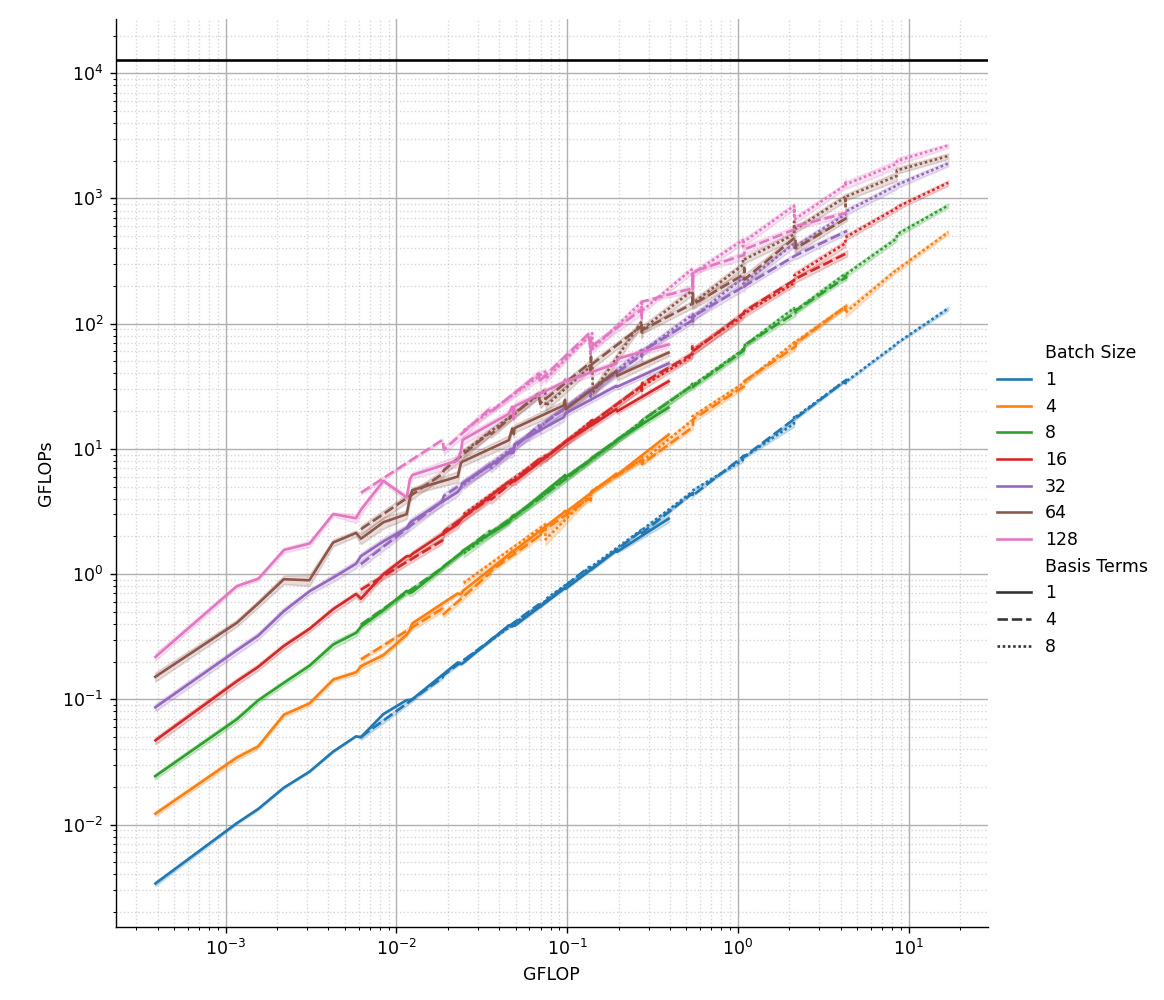

In [482]:
%matplotlib notebook

dsCopy = copy.deepcopy(benchmarkDataset)
dsCopy['Basis Terms'] = dsCopy['Basis Terms'].astype(str)
dsCopy['Cost'] = dsCopy['GFLOP'] / dsCopy['Edges'] * 10**3
dsCopy['Features'] = (dsCopy['Input Features'] * dsCopy['Output Features']).astype(str)
dsCopy['Input Features'] = dsCopy['Input Features'].astype(str)
dsCopy['Output Features'] = dsCopy['Output Features'].astype(str)
dsCopy['Batch Size'] = dsCopy['Batch Size'].astype(str)
g = sns.relplot(dsCopy, kind = 'line', x = 'GFLOP', y = 'GFLOPs',
           hue = 'Batch Size', style = 'Basis Terms', height=8, aspect=1)

for ax in g.axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.axhline(12740 , ls = '-', c = 'black')
    
for ax in g.axes.flatten():
    ax.grid(which = 'major', axis = 'both')
    ax.grid(which = 'minor', axis = 'both', ls = ':', alpha = 0.5)
    ax.set_axisbelow(True)

In [392]:

ds = copy.deepcopy(benchmarkDataset)
ds['Basis Terms'] = ds['Basis Terms'].astype(str)
ds['Cost'] = ds['GFLOP'] / ds['Edges'] * 10**3
ds['Features'] = (ds['Input Features'] * ds['Output Features']).astype(str)
ds['Input Features'] = ds['Input Features'].astype(str)
ds['Output Features'] = ds['Output Features'].astype(str)
import seaborn as sns
g = sns.relplot(ds, kind = 'scatter', x = 'GFLOP', y = 'GFLOPs',
           hue = 'Input Features', style = 'Basis Terms', height=8, aspect=1)

for ax in g.axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.axhline(12740 , ls = '-', c = 'black')
    
for ax in g.axes.flatten():
    ax.grid(which = 'major', axis = 'both')
    ax.grid(which = 'minor', axis = 'both', ls = ':', alpha = 0.5)
    ax.set_axisbelow(True)

<IPython.core.display.Javascript object>


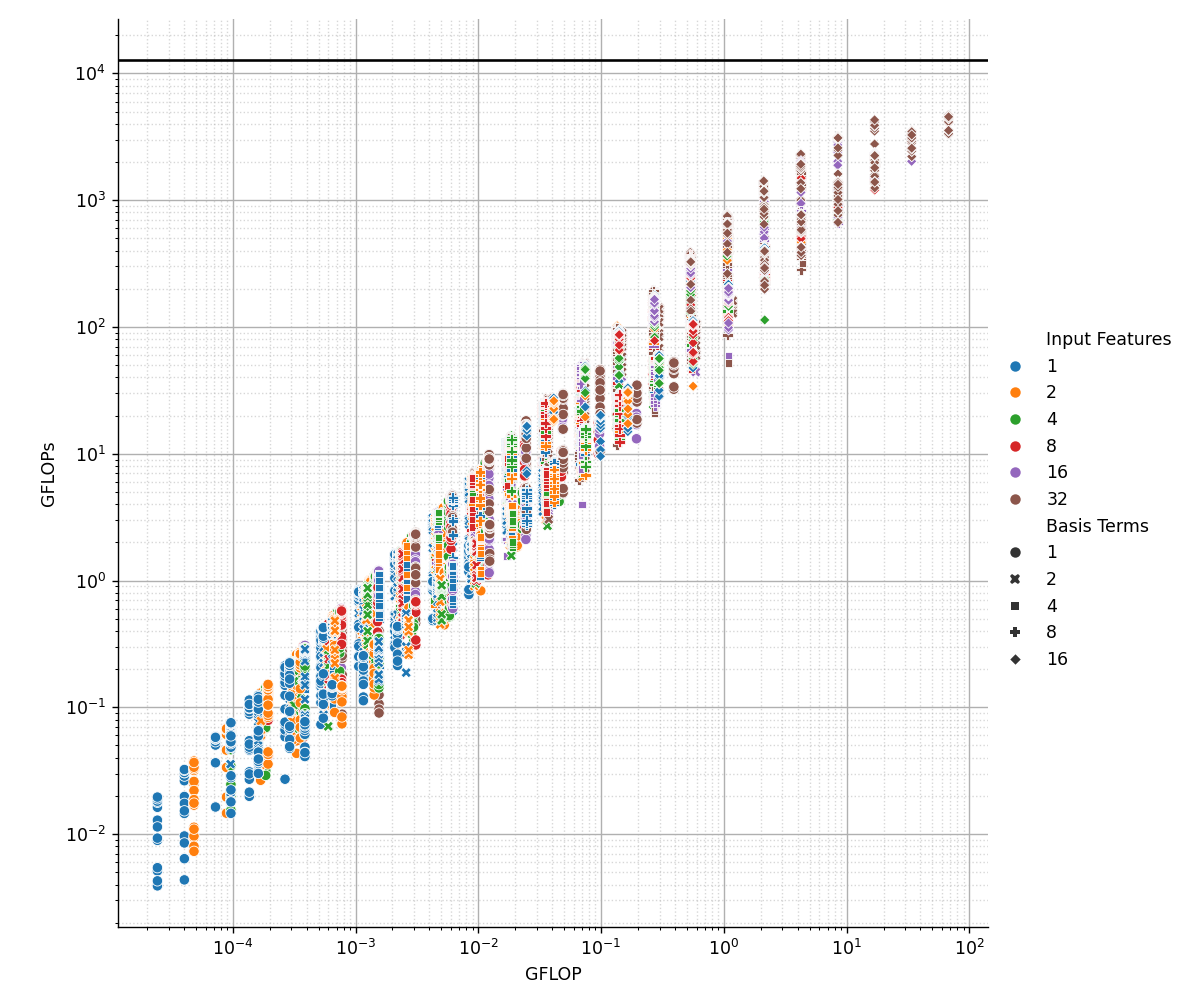

tensor(544193459200)


In [220]:
numSamples = 16
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, with_flops = True) as prof:
    for i in tqdm(range(numSamples)):
        convolutionOp(edge_index, fj, fj, edge_attr, edge_weights, weight, numParticles, 0, [numBasisTerms] * dim, [basis] * dim, [periodic] * dim, cutlassBatchSize, cutlassBatchSize, False).shape

STAGE:2023-11-17 10:09:13 1012396:1012396 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


  0%|          | 0/16 [00:00<?, ?it/s]

STAGE:2023-11-17 10:09:14 1012396:1012396 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-11-17 10:09:14 1012396:1012396 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [265]:

print(si_formatter(FloatingOperations * numSamples))

(1.0848586496, 'T', 'tera')


  0%|          | 0/32 [00:00<?, ?it/s]

' 33.90 GFLOP'

,Number of Samples,Particles,Dimensionality,Neighbors,Edges,Basis,Periodic,Normalized,Basis Terms,Input Features,Output Features,Edge Weights,Batch Size,FLOP,Mean Timing,Min Timing,Max Timing,GFLOPs,Timing
0,32,1024,3,32,32285,dmcf,False,False,8,32,32,True,32,33901832800,84.261768,77.49033,148.630381,228.094907,148.630381
1,32,1024,3,32,32285,dmcf,False,False,8,32,32,True,32,33901832800,84.261768,77.49033,148.630381,311.709255,108.761072
2,32,1024,3,32,32285,dmcf,False,False,8,32,32,True,32,33901832800,84.261768,77.49033,148.630381,415.632689,81.566811
3,32,1024,3,32,32285,dmcf,False,False,8,32,32,True,32,33901832800,84.261768,77.49033,148.630381,431.745731,78.522682
4,32,1024,3,32,32285,dmcf,False,False,8,32,32,True,32,33901832800,84.261768,77.49033,148.630381,408.824837,82.925081
5,32,1024,3,32,32285,dmcf,False,False,8,32,32,True,32,33901832800,84.261768,77.49033,148.630381,429.133259,79.000711
6,32,1024,3,32,32285,dmcf,False,False,8,32,32,True,32,33901832800,84.261768,77.49033,148.630381,424.067785,79.944372
7,32,1024,3,32,32285,dmcf,False,False,8,32,32,True,32,33901832800,84.261768,77.49033,148.630381,430.682585,78.716516
8,32,1024,3,32,32285,dmcf,False,False,8,32,32,True,32,33901832800,84.261768,77.49033,148.630381,415.750566,81.543684
9,32,1024,3,32,32285,dmcf,False,False,8,32,32,True,32,33901832800,84.261768,77.49033,148.630381,432.511347,78.383684


[148.63038063049316, 108.76107215881348, 81.56681060791016, 78.5226821899414, 82.92508125305176, 79.00071144104004, 79.94437217712402, 78.71651649475098, 81.5436840057373, 78.3836841583252, 80.10053634643555, 78.19771766662598, 81.60805702209473, 80.5046558380127, 82.3969841003418, 80.83295822143555, 111.79184913635254, 78.61638069152832, 79.69093322753906, 79.79631423950195, 85.02650260925293, 79.6816349029541, 82.52573013305664, 77.49032974243164, 79.7889232635498, 78.0324935913086, 81.45904541015625, 79.68616485595703, 81.23517036437988, 78.09042930603027, 81.86125755310059, 79.96749877929688]
Mean Sample Time:     84.262 -> 403.65 GFLOPs
Min Sample Time:      77.490 -> 438.92 GFLOPs
Max Sample Time:     148.630 -> 228.84 GFLOPs
Sample Time Stddev:   13.756


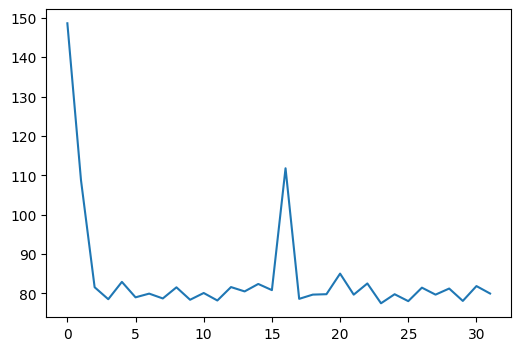

In [259]:
print(timings)

print('Mean Sample Time:   %8.3f -> %ss' % (np.mean(timings), formatFLOP(FloatingOperations / (np.mean(timings) / 1000))))
print('Min Sample Time:    %8.3f -> %ss' % (np.min(timings), formatFLOP(FloatingOperations / (np.min(timings) / 1000))))
print('Max Sample Time:    %8.3f -> %ss' % (np.max(timings), formatFLOP(FloatingOperations / (np.max(timings) / 1000))))
print('Sample Time Stddev: %8.3f' % (np.std(timings)))
fig, axis = plt.subplots(1, 1, figsize=(6, 4), sharex = True, sharey = False, squeeze = False)
axis[0,0].plot(timings)

In [221]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  Total MFLOPs  
------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                          convolution op - Batch         0.09%       1.365ms        98.52%        1.450s      90.651ms            16            --  
            convolution op - Batch - Convolution         0.11%       1.635ms        92.95%        1.368s      85.530ms            16            --  
                                    aten::einsum         7.71%     113.530ms        92.24%        1.358s      84.873ms            16            --  
                                       aten::bmm        78.99%        1.163s        78.99%        1.163s  

In [159]:
fj[edge_index[1]]

tensor([[ 1.4515,  0.1961, -1.2238,  ..., -0.9383,  0.6211,  0.2635],
        [-0.7599,  0.9058,  1.3625,  ..., -0.0107, -0.1270, -2.3412],
        [-0.2908,  0.4731, -0.9754,  ...,  0.8240, -1.0121,  0.2702],
        ...,
        [-0.7313,  0.2545,  1.0855,  ..., -1.2279, -0.0662,  0.8813],
        [-1.0249,  0.0805,  1.4249,  ..., -0.1503, -0.5211, -0.1521],
        [-0.3111,  0.3927,  2.2693,  ...,  0.0839,  0.0853,  1.0397]])

In [77]:
e = (16**3) * 32
d = 3
n = 8
i = 32
o = 32
FLOPs = e * (n**d + 2 * n**d * i * o + i*o - o)
si_formatter(FLOPs)

(137.63608576, 'G', 'giga')

In [66]:
u = torch.normal(torch.zeros((e,n)), torch.ones((e,n)))
v = torch.normal(torch.zeros((e,n)), torch.ones((e,n)))
w = torch.normal(torch.zeros((e,n)), torch.ones((e,n)))
weights = torch.normal(torch.zeros([n,n,n,i,o]), torch.ones(n,n,n,i,o))
features = torch.normal(torch.zeros((e,i)), torch.ones((e,i)))

In [67]:
oe.contract_path('nu,nv,nw,uvwio, ni -> no', u,v,w,weights,features)

([(0, 1), (0, 3), (0, 2), (0, 1)],
   Complete contraction:  nu,nv,nw,uvwio,ni->no
          Naive scaling:  6
      Optimized scaling:  6
       Naive FLOP count:  4.295e+10
   Optimized FLOP count:  1.746e+10
    Theoretical speedup:  2.460e+0
   Largest intermediate:  1.342e+8 elements
 --------------------------------------------------------------------------------
 scaling        BLAS                current                             remaining
 --------------------------------------------------------------------------------
    3              0             nv,nu->nvu                   nw,uvwio,ni,nvu->no
    4              0           nvu,nw->nvuw                     uvwio,ni,nvuw->no
    6           TDOT        nvuw,uvwio->nio                            ni,nio->no
    3              0             nio,ni->no                                no->no)

In [73]:
cutlassBatchSize = 128
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, with_flops = True) as prof:
    frame = benchmarkNetwork(32, 3, 32, 1, 'cartesian', 'linear', 4, 4, [32, 32, 1], None, 2)


STAGE:2023-11-16 09:26:52 1012396:1012396 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


  0%|          | 0/2 [00:00<?, ?it/s]

STAGE:2023-11-16 09:26:52 1012396:1012396 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-11-16 09:26:52 1012396:1012396 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


OutOfMemoryError: CUDA out of memory. Tried to allocate 854.00 MiB. GPU 0 has a total capacty of 11.73 GiB of which 814.56 MiB is free. Process 57415 has 16.77 MiB memory in use. Process 928938 has 3.58 GiB memory in use. Including non-PyTorch memory, this process has 5.82 GiB memory in use. Of the allocated memory 5.45 GiB is allocated by PyTorch, and 231.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [22]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
autograd::engine::evaluate_function: cutlassBackward...         0.01%     205.000us        60.19%        1.737s     289.426ms       0.000us         0.00%        1.636s     272.670ms             6            --  
                                        cutlassBackward         0.04%       1.026ms        60.17%        1.736s     289.360ms       0.000us         0.0

In [19]:

prof.export_chrome_trace("trace.json")

In [13]:
# performanceDataset = pd.DataFrame()
# for arch in tqdm([[32, 32, 1]]):
#     for [nx, dim] in tqdm([[64, 2]]):
#         for n in tqdm([32], leave = False):
#             for batch_size in tqdm([4], leave = False):
#                 for window_fn in tqdm(['Mueller'], leave = False):
#                     for cmap in tqdm(['preserving'] if dim != 1 else ['cartesian'], leave = False):
#                         for rbf in tqdm(['dmcf'], leave = False):
#                             frame = benchmarkNetwork(nx, dim, numNeighbors, fluidFeatures, cmap, rbf, n, batch_size, arch, window_fn, performanceSamples)
#                             performanceDataset = pd.concat((performanceDataset, frame), ignore_index = True)
# #                             performanceDataset.to_csv('performance [nx = %4d, dim = %d, arch = %s].csv' % (nx, dim, arch))

In [15]:
import seaborn as sns

In [12]:

metrics =  ['Gradient Update', 'Neighborsearch', 'Forward Pass', 'Loss Computation', 'Backward Pass']
metrics =  ['Forward Pass', 'Backward Pass']
pivotedDataset = pivotDS(performanceDataset,metrics = metrics)

  0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
display(performanceDataset)

,Sample,Number of Particles,Dimensionality,Neighborhood Size,Fluid Features,Coordinate Mapping,Window Function,Base Function,Terms,Batch Size,Network Architecture,Gradient Update,Neighborsearch,Forward Pass,Loss Computation,Backward Pass
0,0,4096,2,32,1,Cartesian,None,LinCConv,1,1,1,1270.310913,0.007359,900.568054,0.242688,369.133575
1,1,4096,2,32,1,Cartesian,None,LinCConv,1,1,1,11.627520,0.007359,5.900416,0.145408,5.491712
2,2,4096,2,32,1,Cartesian,None,LinCConv,1,1,1,12.612608,0.007359,6.067200,0.277504,6.202368
3,3,4096,2,32,1,Cartesian,None,LinCConv,1,1,1,11.525120,0.007359,5.419008,0.128000,5.883904
4,4,4096,2,32,1,Cartesian,None,LinCConv,1,1,1,11.860992,0.007359,6.117376,0.144384,5.505024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76795,59,4096,2,32,1,Ummenhofer et al.,Müller,DMCF,32,4,1,128.594940,0.011229,89.989120,0.263168,38.135807
76796,60,4096,2,32,1,Ummenhofer et al.,Müller,DMCF,32,4,1,130.726913,0.011229,92.909569,0.229376,37.329922
76797,61,4096,2,32,1,Ummenhofer et al.,Müller,DMCF,32,4,1,120.931328,0.011229,44.633087,0.117760,75.953156
76798,62,4096,2,32,1,Ummenhofer et al.,Müller,DMCF,32,4,1,124.490753,0.011229,48.385025,0.112640,75.832321


In [16]:
hueVar = 'Base Function'
actualBases,palette = getPalette(hueVar, pivotedDataset)

def filterDS(dataset, col, p = 0.05):
    q_low = dataset[col].quantile(p)
    q_hi  = dataset[col].quantile(1-p)

    return dataset[(dataset[col] < q_hi) & (dataset[col] > q_low)]

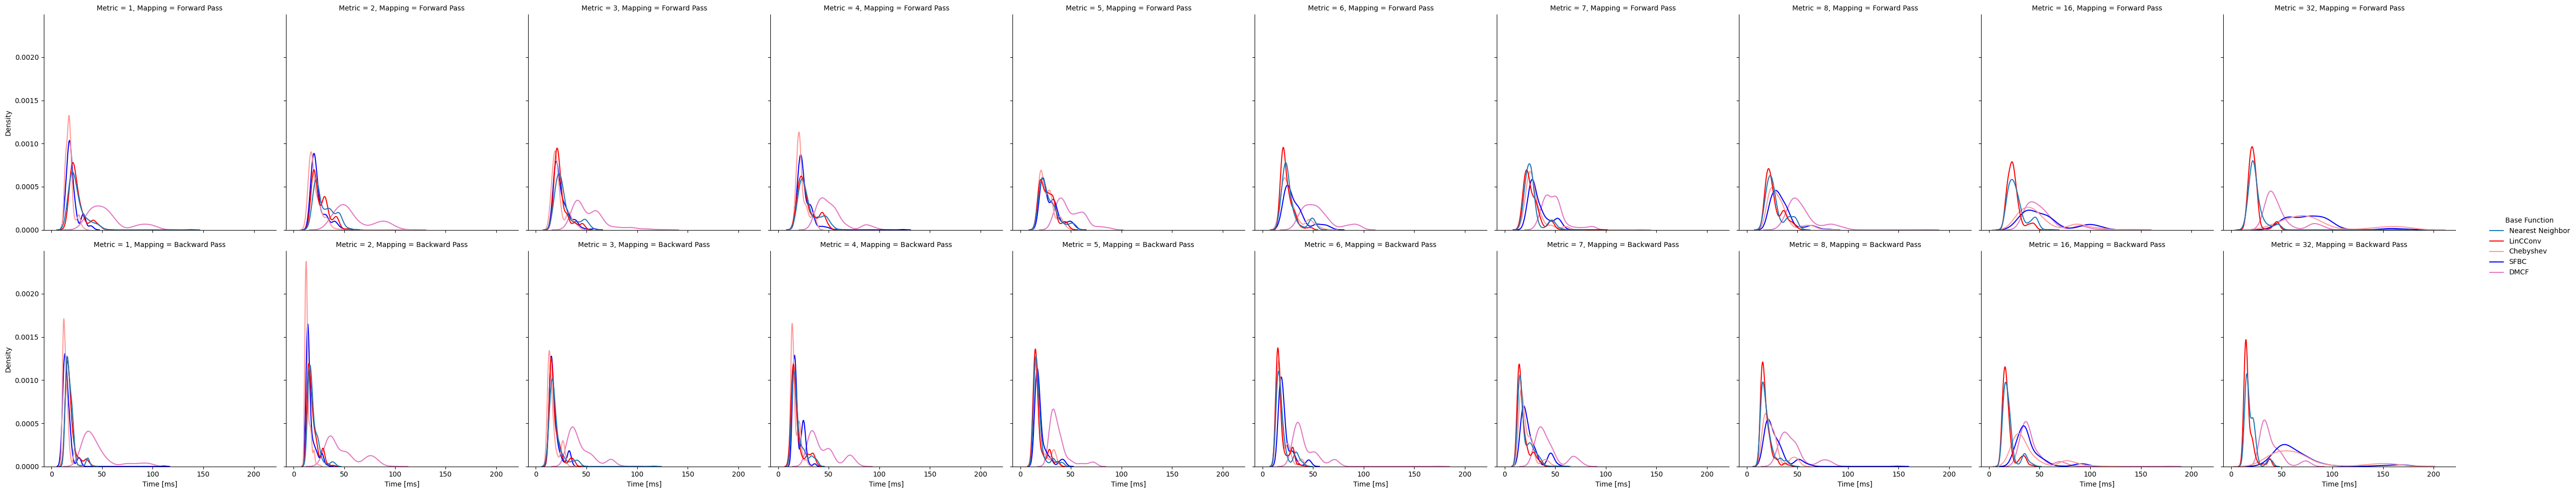

In [17]:
import seaborn as sns
g = sns.displot(data = filterDS(pivotedDataset[pivotedDataset['Batch Size'] == 4], 'value', 0.001), 
            x = 'value', 
            kind = 'kde', 
            row = 'metric', row_order = metrics,
#             row = 'Coordinate Mapping', row_order = None,
            col = 'Terms', col_order = None,
            hue = hueVar, hue_order = actualBases if hueVar == 'Base Function' else None, palette = palette,
            facet_kws = {'sharey': True, 'sharex': True}
            )

g.set_axis_labels('Time [ms]','Density')
g.set_titles('Metric = {col_name}, Mapping = {row_name}')

# g.despine(left=True)
# g.set_titles('')

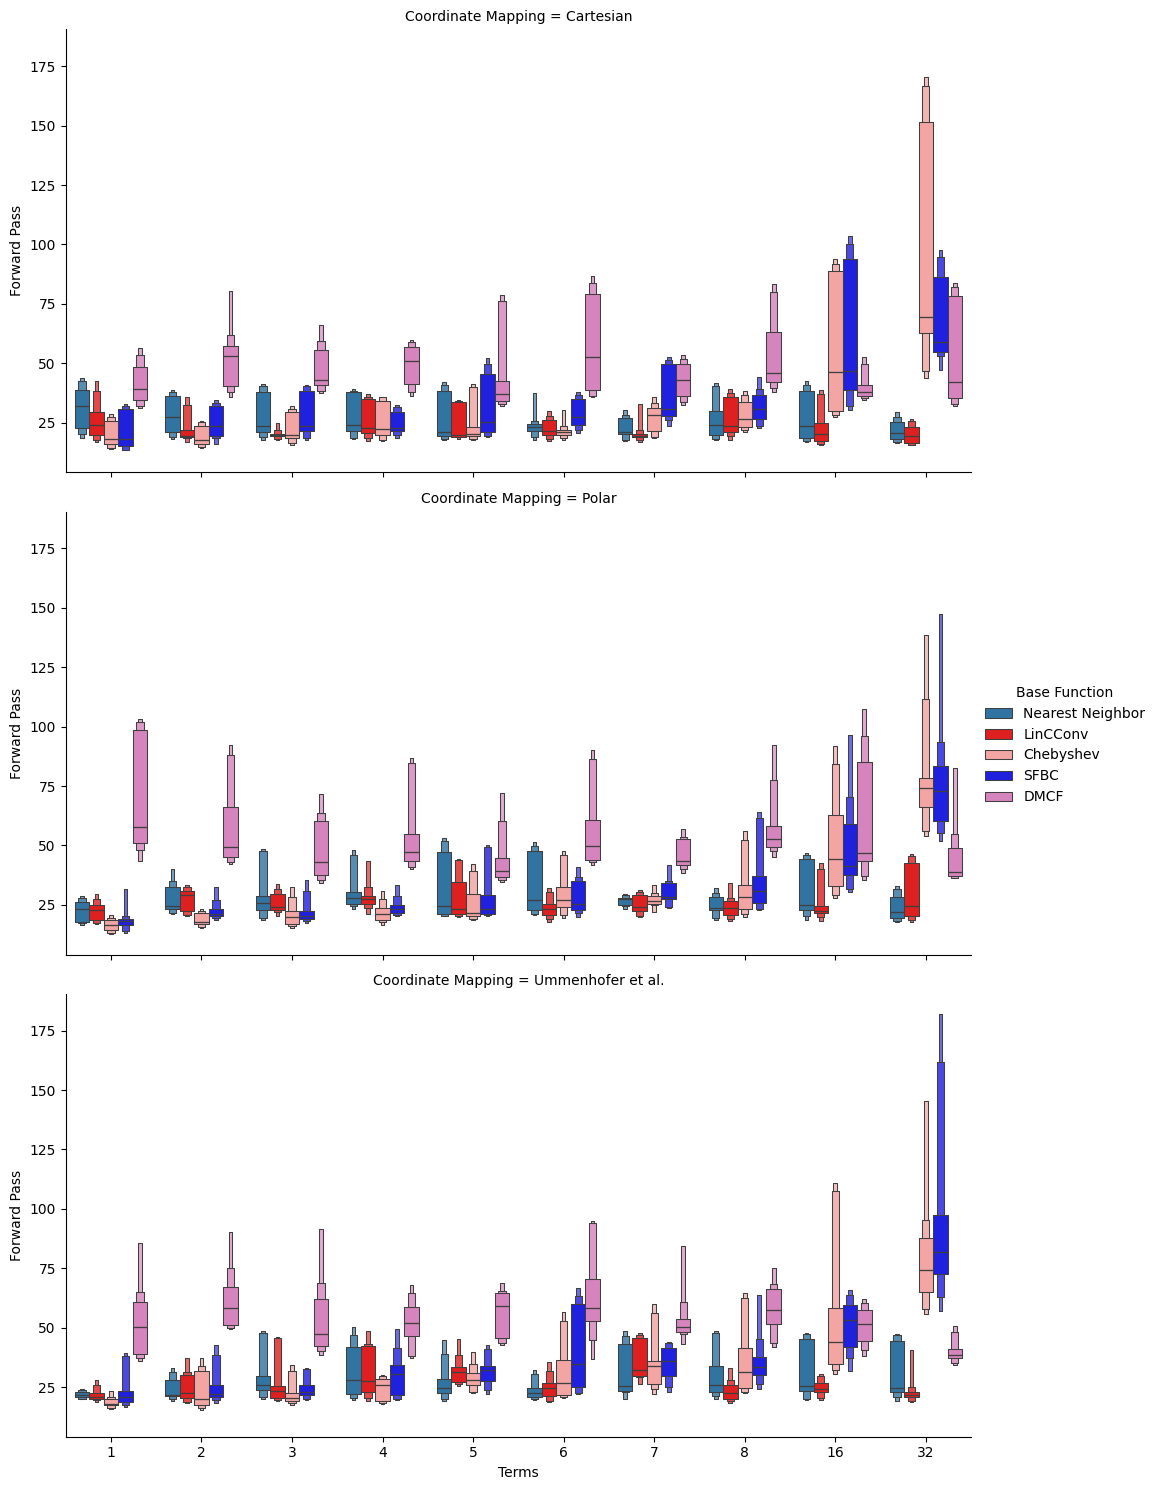

In [19]:
sns.catplot(data = performanceDataset[np.logical_and(performanceDataset['Window Function'] == "None", performanceDataset['Batch Size'] == 4)],
            x = 'Terms',
            y = 'Forward Pass',
            hue = hueVar, hue_order = actualBases if hueVar == 'Base Function' else None, palette = palette,
            kind = 'boxen', showfliers = False, aspect = 2,
            row = 'Coordinate Mapping'
           )      

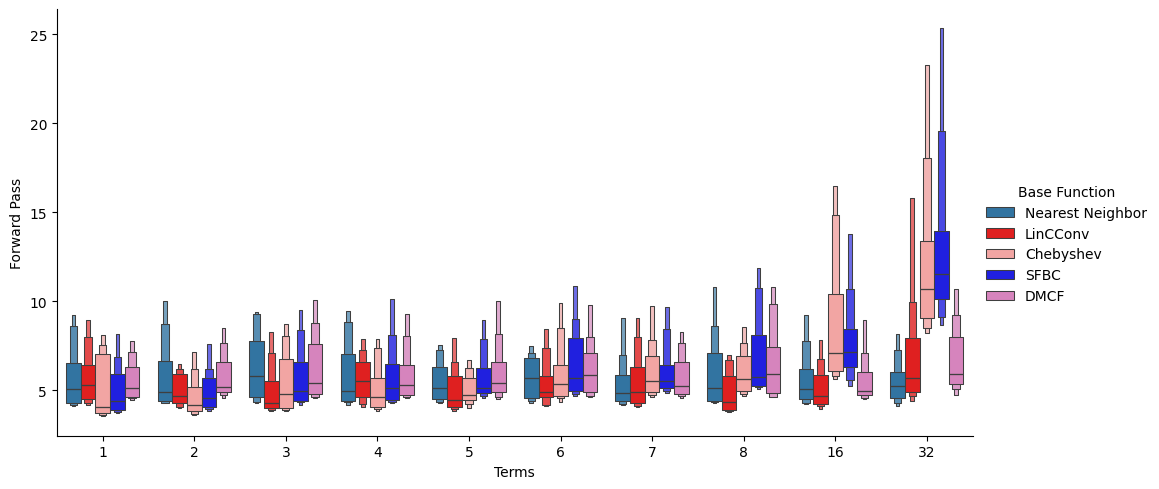

In [321]:
sns.catplot(data = performanceDataset[np.logical_and(performanceDataset['Window Function'] == "None", performanceDataset['Batch Size'] == 4)],
            x = 'Terms',
            y = 'Forward Pass',
            hue = hueVar, hue_order = actualBases if hueVar == 'Base Function' else None, palette = palette,
            kind = 'boxen', showfliers = False, aspect = 2
           )      

In [335]:
basisFunctions = performanceDataset['Base Function'].unique()
baseFunctionOrdering = ['Nearest Neighbor', 'LinCConv', 'DMCF', 'SplineConv', 'SFBC', 'Fourier', 'Fourier (4-Terms)','Fourier (5-Terms)', 'Fourier (even)', 'Fourier (odd)','Fourier (odd) + x','Fourier (odd) + sgn(x)', 'Chebyshev', 'Chebyshev (2nd kind)', 'Gaussian Kernel', 'Müller Kernel', 'Wendland-2', 'Quartic Spline', 'Spiky', 'Bump RBF']
# baseFunctions = sorted([b for b in basisFunctions if b in baseFunctionOrdering], key = lambda x: baseFunctionOrdering.index(x))

In [353]:
pivotedData2 = performanceDataset[performanceDataset['Batch Size']== 4].pivot_table(
    values = ['Forward Pass', 'Backward Pass'], 
    index = 'Base Function', 
    columns = ['Terms'], 
    aggfunc = "mean").sort_values(by = 'Base Function', key = lambda column: column.map(lambda e: baseFunctionOrdering.index(e)), inplace = False)

pivotedData2 = pivotedData2.style.format(precision=2, thousands=",", decimal=".")
display(pivotedData2)
